In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# -------------------------------
TRAIN_PATH  = "data/digit-recognizer/train.csv"
TEST_PATH   = "data/digit-recognizer/test.csv"
SUBM_PATH   = "data/digit-recognizer/sample_submission.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)
subm_df  = pd.read_csv(SUBM_PATH)

print("train_df:", train_df.shape)
print("test_df :", test_df.shape)
print("subm_df :", subm_df.shape)

train_df: (42000, 785)
test_df : (28000, 784)
subm_df : (28000, 2)


In [28]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
subm_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [31]:
Y_train = train_df["label"].values
X_train = train_df.drop(columns="label").values  # flatten the data frame to a vector for each pixel
X_test  = test_df.values

print("X_train :", X_train.shape)
print("Y_train :", Y_train.shape)
print("X_test:", X_test.shape)

X_train : (42000, 784)
Y_train : (42000,)
X_test: (28000, 784)


In [32]:
pd.Series(Y_train).value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: count, dtype: int64

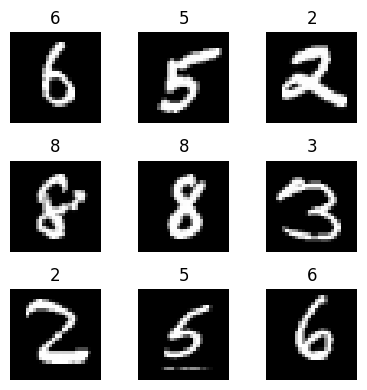

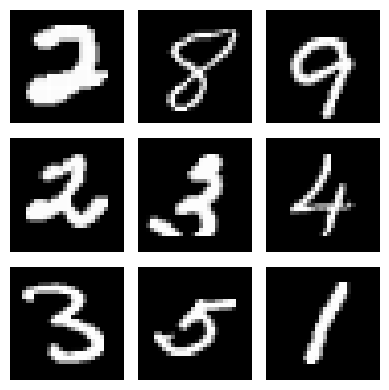

In [33]:
def plot_digits(images, labels=None, n=9):
    rows = int(np.sqrt(n))
    fig, axes = plt.subplots(rows, rows, figsize=(4,4))
    for ax, idx in zip(axes.ravel(), np.random.choice(len(images), n, replace=False)):
        ax.imshow(images[idx].reshape(28,28), cmap="gray")
        if labels is not None:
            ax.set_title(labels[idx])
        ax.axis("off")
    plt.tight_layout(); plt.show()

plot_digits(X_train, labels = Y_train)   # training set
plot_digits(X_test)   

In [34]:
# Basically convert the gray scale values from 0 to 255 to float values from 0.0 ro 1.1
# 2-a. cast to float32
X_test = X_test.astype(np.float32)
X_train = X_train.astype(np.float32)

# 2-b. scale pixels to [0,1]
X_test /= 255
X_train /= 255 

print("min / max in X_all:", X_test.min(), X_test.max())

min / max in X_all: 0.0 1.0


In [35]:
VALIDATION_SIZE = 5000 # the acctual testing (validation)

# Build an index array 0 … N-1
indices_all = np.arange(len(X_train))      # X_train still holds 42 000 rows
# Shuffle *in-place* so X and y keep the same order
np.random.seed(42)                         # reproducible shuffle
np.random.shuffle(indices_all)

validation_indices = indices_all[:VALIDATION_SIZE] # 0 to 5000 shuffeled positions
training_indices   = indices_all[VALIDATION_SIZE:] # 5000 to 42000

X_validation, Y_validation = X_train[validation_indices], Y_train[validation_indices] 
X_train,      Y_train      = X_train[training_indices],  Y_train[training_indices]

print("X_train     :", X_train.shape,  Y_train.shape)       # (37000, 784) (37000,)
print("X_validation:", X_validation.shape, Y_validation.shape) # (5000, 784) (5000,)

X_train     : (37000, 784) (37000,)
X_validation: (5000, 784) (5000,)


In [36]:

# Hyper-parameters
learning_rate     = 0.01      # step size for gradient descent
number_of_epochs  = 30
mini_batch_size   = 64
number_of_inputs  = 784       # 28 × 28
number_of_classes = 10

In [37]:
# Parameter initialisation
rng = np.random.default_rng(seed=0)

weights_input_to_output = rng.normal(
    loc=0.0, scale=0.01,  # small Gaussian
    size=(number_of_inputs, number_of_classes)   # 784 × 10
).astype(np.float32)

biases_output = np.zeros((1, number_of_classes), dtype=np.float32)

In [38]:
# Helper functions
def softmax(logits):
    # subtract row-wise max for numeric stability
    shifted = logits - np.max(logits, axis=1, keepdims=True)
    exp_scores = np.exp(shifted)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def cross_entropy_loss(probs, labels):
    """
    probs  : shape (batch, classes) – soft-max outputs
    labels : shape (batch,)         – integers 0-9
    """
    return -np.log(probs[np.arange(len(labels)), labels]).mean()

In [39]:
# ---------- forward pass ----------
def forward_pass(features):
    """
    features : (batch, 784)  – pixel inputs
    returns  : (batch, 10)   – class probabilities
    """
    logits = features @ weights_input_to_output + biases_output  # linear scores
    return softmax(logits)                                       # turn into probs


# ---------- backward pass ----------
def backward_pass(features, probs, labels):
    """
    features : (batch, 784)
    probs    : (batch, 10) – soft-max output from forward_pass
    labels   : (batch,)    – true class indices 0-9
    returns  : gradients for weights and biases
    """
    batch = len(labels)

    # error signal: (probs - one_hot) / batch
    delta = probs.copy()
    delta[np.arange(batch), labels] -= 1
    delta /= batch

    grad_weights = features.T @ delta          # (784 × batch) · (batch × 10)
    grad_biases  = delta.sum(0, keepdims=True) # (1, 10)

    return grad_weights, grad_biases

In [40]:
number_of_batches = int(np.ceil(len(X_train) / mini_batch_size))

for epoch in range(1, number_of_epochs + 1):

    # --- shuffle training data each epoch ---
    permutation = rng.permutation(len(X_train))
    X_train_shuffled = X_train[permutation]
    Y_train_shuffled = Y_train[permutation]

    running_loss = 0.0

    for batch in range(number_of_batches):
        start = batch * mini_batch_size
        end   = min(start + mini_batch_size, len(X_train))

        batch_features = X_train_shuffled[start:end]
        batch_labels   = Y_train_shuffled[start:end]

        # Forward ---------
        batch_probabilities = forward_pass(batch_features)
        batch_loss = cross_entropy_loss(batch_probabilities, batch_labels)
        running_loss += batch_loss

        # Backward --------
        grad_W, grad_b = backward_pass(batch_features,
                                       batch_probabilities,
                                       batch_labels)

        # Update ----------
        weights_input_to_output -= learning_rate * grad_W
        biases_output           -= learning_rate * grad_b

    # ---- validation metrics at epoch end ----
    validation_probabilities = forward_pass(X_validation)
    validation_predictions   = validation_probabilities.argmax(axis=1)
    validation_accuracy      = (validation_predictions == Y_validation).mean()

    print(f"Epoch {epoch:02d} | "
          f"Train Loss {running_loss/number_of_batches:.4f} | "
          f"Val Acc {validation_accuracy*100:.2f}%")

Epoch 01 | Train Loss 1.1597 | Val Acc 84.42%
Epoch 02 | Train Loss 0.6456 | Val Acc 86.36%
Epoch 03 | Train Loss 0.5364 | Val Acc 87.14%
Epoch 04 | Train Loss 0.4835 | Val Acc 87.68%
Epoch 05 | Train Loss 0.4512 | Val Acc 88.12%
Epoch 06 | Train Loss 0.4282 | Val Acc 88.38%
Epoch 07 | Train Loss 0.4119 | Val Acc 88.66%
Epoch 08 | Train Loss 0.3982 | Val Acc 89.08%
Epoch 09 | Train Loss 0.3884 | Val Acc 89.28%
Epoch 10 | Train Loss 0.3796 | Val Acc 89.22%
Epoch 11 | Train Loss 0.3712 | Val Acc 89.34%
Epoch 12 | Train Loss 0.3647 | Val Acc 89.30%
Epoch 13 | Train Loss 0.3595 | Val Acc 89.48%
Epoch 14 | Train Loss 0.3539 | Val Acc 89.66%
Epoch 15 | Train Loss 0.3498 | Val Acc 89.58%
Epoch 16 | Train Loss 0.3453 | Val Acc 89.84%
Epoch 17 | Train Loss 0.3419 | Val Acc 89.82%
Epoch 18 | Train Loss 0.3388 | Val Acc 89.90%
Epoch 19 | Train Loss 0.3352 | Val Acc 89.94%
Epoch 20 | Train Loss 0.3327 | Val Acc 89.98%
Epoch 21 | Train Loss 0.3297 | Val Acc 90.18%
Epoch 22 | Train Loss 0.3272 | Val

In [41]:
test_probabilities = forward_pass(X_test)
test_predictions   = test_probabilities.argmax(axis=1)  # (28 000,)

# Fill the Kaggle submission DataFrame
subm_df["Label"] = test_predictions
subm_df.to_csv("submission_softmax_baseline.csv", index=False)
print("Submission saved -> submission_softmax_baseline.csv")

Submission saved -> submission_softmax_baseline.csv
